2 method, both in during embedding process
- alpha as key
- (HASH) apply key, hash the key, then use bitwise XOR (key with the flatten watermark array), then embed

## DWT and IDWT method

In [1]:
def apply_dwt(img, wavelet='haar'):
    return pywt.dwt2(img, wavelet)

def inverse_dwt(dwt, wavelet='haar'):
    LL, (HL, LH, HH) = dwt
    return pywt.idwt2((LL, (HL, LH, HH)), wavelet)

## DCT and IDCT method

In [2]:
def apply_dct(image_array):
    size = len(image_array[0]) # get width of image
    
    all_subdct = np.empty((size, size)) # create empty array for dct img
    
    # range (start, stop, step)
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct


def inverse_dct(all_subdct):
    size = len(all_subdct[0])
    
    all_subidct = np.empty((size, size))
    
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct
            
    return all_subidct


## Embed and Extract watermark (HASH)

In [3]:
import hashlib

def generate_key(string):
    """Generates a secret key from the watermark string using SHA-256.

    Args:
      watermark_string: The secret string to use for key generation.

    Returns:
      A bytes object representing the secret key.
    """
    # Encode the string to bytes and get the digest (key)
    key_bytes = hashlib.sha256(string.encode()).digest()

    # Convert the key bytes to a NumPy array of uint8 (unsigned 8-bit integers)
    secret_key = np.frombuffer(key_bytes, dtype=np.uint8)
        
    return secret_key

In [13]:
# Lower alpha value for less impact
def embed_watermark(orig_image, watermark, key = None, alpha = 0.00001):
  
    # apply dwt, then dct
    LL, (HL, LH, HH) = apply_dwt(orig_image)
    dct_img = apply_dct(LL)
    
    #ravel(): return a contiguous flattened 1D array
    height, width = LL.shape
    resized_watermark = cv2.resize(watermark, (height//16, width//16))
    watermark_flat = resized_watermark.ravel()
    
    ## resize generated_key to same length as watermark_flat
    generated_key = generate_key(key)
    generated_key = np.tile(generated_key, len(watermark_flat) // len(generated_key) + 1)[:len(watermark_flat)]
    
    # encryption
    encrypted_watermark = np.bitwise_xor(watermark_flat, generated_key).astype(np.uint8)
    
    ind = 0
    for y in range (0, height, 16):
        for x in range (0, width,16):
            if ind < len(watermark_flat):
                # get the sub dct
                subdct = dct_img[y:y+16, x:x+16]
                subdct[15][15] = encrypted_watermark[ind] * alpha
                dct_img[y:y+16, x:x+16] = subdct
                ind += 1
      
    #inverse dct
    idct_img = inverse_dct(dct_img)
    
    #inverse dwt
    idwt_img = inverse_dwt((idct_img, (HL, LH, HH)))
        
    return idwt_img

def extract_watermark(orig_image, key = None, alpha = 0.00001):
    # apply dwt, then dct
    LL, (HL, LH, HH) = apply_dwt(orig_image)
    dct_watermarked_img = apply_dct(LL)
    
    # Pre-allocate for watermark
    height, width = LL.shape
    encrypted_watermark = np.zeros((width//16) **2)  
    
    ind = 0
    for y in range (0, height, 16):
        for x in range (0, width, 16):
            if ind < len(encrypted_watermark):
                subdct = dct_watermarked_img[y:y+16, x:x+16]
                encrypted_watermark[ind] = subdct[15][15] / alpha
                ind += 1

    ##round the value first
    ##some of the the value will get like 10.99999 or 10.00001
    encrypted_watermark = np.round(encrypted_watermark).astype(np.uint8)
#     print("extract_watermark :", encrypted_watermark)

    ## resize generated_key to same length as watermark_flat
    generated_key = generate_key(key)
    generated_key = np.tile(generated_key, len(encrypted_watermark) // len(generated_key) + 1)[:len(encrypted_watermark)]
    
    watermark = np.bitwise_xor(encrypted_watermark, generated_key).astype(np.uint8)
    
    # Reshape the extracted watermark to its original size
    watermark = watermark.reshape(height // 16, width // 16)
    

    return watermark

## simplified dicom image operation method

In [5]:
def load_dicom(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array
    return image, ds

def save_dicom(path, image, original_dicom):
    original_dicom.PixelData = image.astype(np.uint16).tobytes()
    original_dicom.save_as(path)


## Attack

In [6]:
## !pip install  scikit-image

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_ubyte
from skimage.filters import gaussian, median
from skimage.util import random_noise
from skimage.transform import resize
from skimage.io import imsave, imread
from io import BytesIO
from PIL import Image
import pywt

def apply_attacks_and_extract(dicom_image, extract_function):
    image = img_as_float(dicom_image.copy())  # Ensure image is in the right format for attacks
    attacked_images = apply_attacks(image)
    extracted_watermarks = {}

    for name, attacked_img in attacked_images.items():
        extracted_watermarks[name] = extract_function(img_as_float(attacked_img), "test")

    num_attacks = len(attacked_images)
    fig, axs = plt.subplots(num_attacks, 2, figsize=(10, 2 * num_attacks))

    for i, (attack_name, attacked_img) in enumerate(attacked_images.items()):
        axs[i, 0].imshow(attacked_img, cmap='gray')
        axs[i, 0].set_title(f"{attack_name} - Attacked")
        axs[i, 0].axis('off')

        if extracted_watermarks.get(attack_name) is not None:
            axs[i, 1].imshow(extracted_watermarks[attack_name], cmap='gray')
            axs[i, 1].set_title(f"{attack_name} - Extracted")
            axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

def apply_attacks(image):
    attacks = {
        "Without Attack": lambda x: x,
        "Minimal Gaussian Blur": lambda x: gaussian(x, sigma=1),
        "Moderate Gaussian Blur": lambda x: gaussian(x, sigma=2),
        "Median Filtering": lambda x: median(x),
        "JPEG Compression - Low": lambda x: jpeg_compression(x, quality=85),
        "JPEG Compression - High": lambda x: jpeg_compression(x, quality=50),
        "Scaling Attack - Down & Up": lambda x: scale_down_up(x),
        "Very Light Smoothing": lambda x: gaussian(x, sigma=0.5)
    }

    attacked_images = {}
    for name, attack_func in attacks.items():
        attacked_images[name] = attack_func(image.copy())

    return attacked_images

import cv2
import numpy as np

def jpeg_compression(dicom_image, quality=85):
    # Check if the image is already in 8-bit format, if not, normalize and convert
    if dicom_image.dtype != np.uint8:
        # Normalize the image to 0-255 range
        max_value = np.max(dicom_image)
        min_value = np.min(dicom_image)
        normalized_image = 255 * (dicom_image - min_value) / (max_value - min_value)
        image_8bit = normalized_image.astype(np.uint8)
    else:
        image_8bit = dicom_image

    # Set JPEG quality level for compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encoded_image = cv2.imencode('.jpg', image_8bit, encode_param)
    if result:
        decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_UNCHANGED)

        # Check if color conversion is necessary (if original was color, convert back to grayscale)
        if len(decoded_image.shape) == 3 and decoded_image.shape[2] == 3:
            decoded_image = cv2.cvtColor(decoded_image, cv2.COLOR_BGR2GRAY)
        return decoded_image
    else:
        raise Exception("Image encoding failed.")


def scale_down_up(image, scale_factor=0.5):
    height, width = image.shape[:2]
    resized_down = resize(image, (int(height * scale_factor), int(width * scale_factor)), anti_aliasing=True)
    resized_up = resize(resized_down, (height, width), anti_aliasing=True)
    return resized_up


## Test Embed

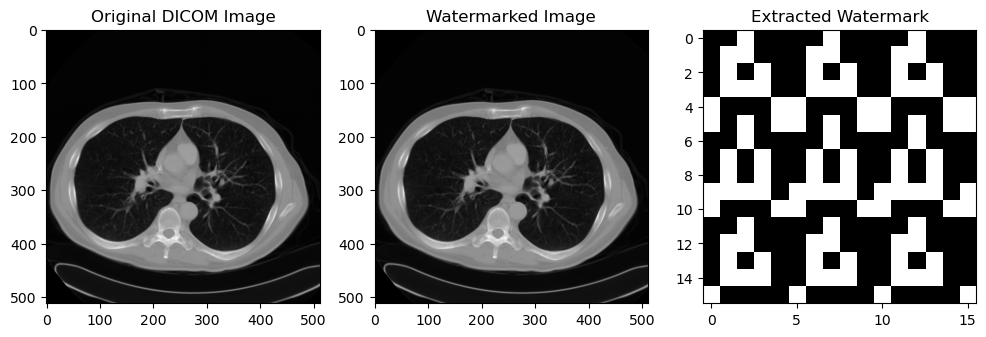

In [18]:
import numpy as np
import cv2
import pydicom
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize)

dicom_path = "medical-img.dcm"
watermark_path = "64_binary_img.png"

dicom_image, ds = load_dicom(dicom_path)
# print("dicom img : ", dicom_image[400])

watermark_image = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
watermark_image = (watermark_image > 128).astype(np.uint8) # Convert to binary (0 or 1)

watermarked_image = embed_watermark(dicom_image, watermark_image, "test")

# save_dicom("watermarked_dicom.dcm", watermarked_image, ds)

extracted_watermark = extract_watermark(watermarked_image, "test")

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(dicom_image, cmap='gray')
plt.title('Original DICOM Image')
plt.subplot(132)
plt.imshow(watermarked_image, cmap='gray')
plt.title('Watermarked Image')
plt.subplot(133)
plt.imshow(extracted_watermark, cmap='gray')
plt.title('Extracted Watermark')
plt.show()

## Calculate PSNR

In [15]:
psnr_value = cv2.PSNR(dicom_image.astype(np.float32), watermarked_image.astype(np.float32))
print(f"PSNR Value: {psnr_value} dB")

PSNR Value: 55.8995883577499 dB


## Test Attack

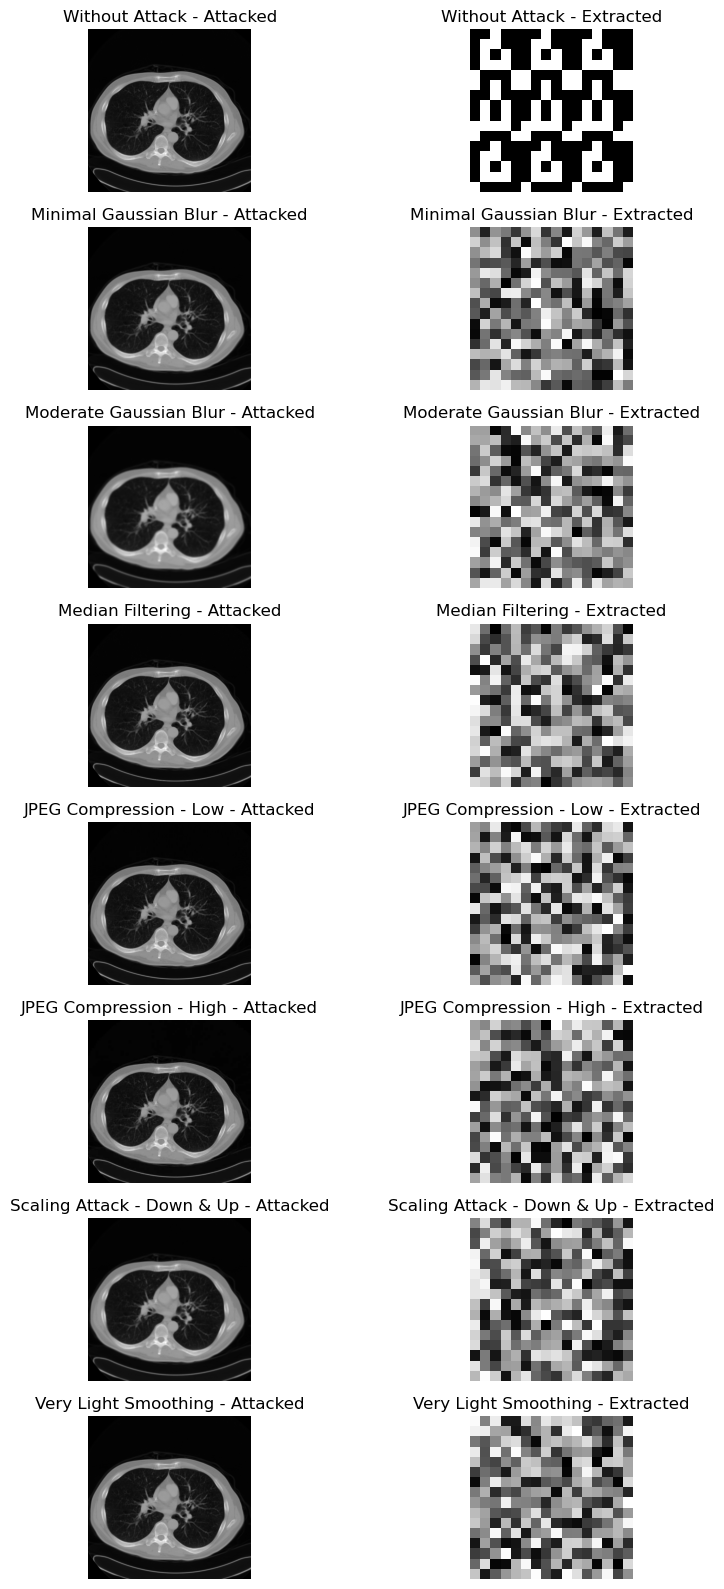

In [16]:
apply_attacks_and_extract(watermarked_image, extract_watermark)